In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pybdshadow
from shapely.geometry import Polygon

In [2]:
#Read building data
buildings = gpd.read_file(r'../example/data/bd_demo.json')
buildings = pybdshadow.bd_preprocess(buildings)

In [3]:
#Define study area
bounds = [139.707846,35.543637,139.718567,35.553909]
from shapely.geometry import Polygon
studyarea = gpd.GeoDataFrame({'geometry':[Polygon([[bounds[0],bounds[1]],
         [bounds[0],bounds[3]],
         [bounds[2],bounds[3]],
         [bounds[2],bounds[1]]])]})


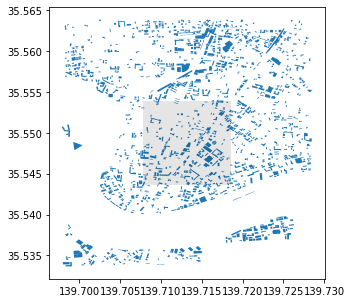

In [4]:
#Plot study area
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(1,(5,5))
ax = plt.subplot(111)

buildings.plot(ax = ax)
studyarea.plot(ax = ax,facecolor =(0,0,0,0.1))
plt.show()

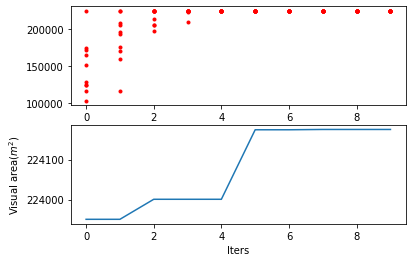

{'orientation': 0.2999774196867411,
 'height': 109.9583720763894,
 'brandCenter': [139.7085186850638, 35.551562453288675]}

In [5]:
#优化广告参数
ad_params = pybdshadow.ad_optimize(bounds,
                                   buildings,
                                   height_range=[100,200],
                                   printlog=True,
                                   size_pop=10,
                                   max_iter=10,
                                   prob_mut=0.001,
                                   precision=1e-7)
ad_params


In [8]:
#calculate the visual area
visualArea,shadows = pybdshadow.ad_visualArea(ad_params,buildings)

#Generate a GeoDataFrame from ad_params for visualization
billboard_gdf = pybdshadow.ad_to_gdf(ad_params,billboard_height = 100)

#Visualize buildings, shadows, billboard and visual area
pybdshadow.show_bdshadow(buildings=buildings,
                         shadows=shadows,
                         ad=billboard_gdf,
                         ad_visualArea=visualArea)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'lz48o1', 'type': '…